# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder


# Functions

## Activation functions and their derivatives

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)  # Assume x is already sigmoid(x)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    


## Loss functions

In [3]:
def mean_squared_error(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))
    
""" slightly different formula """
def cross_entropy(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred + 1e-9)) / y_true.shape[0]

## Main Class

In [4]:
class MLP:
    def __init__(self, layers, activations, input_size, output_size, init_method='standard'):
        self.layers = layers  # list of just hidden layers
        self.activations = activations  #list('sigmoid' or 'relu')
        
        self.weights = []
        self.biases = []
        
        # Initialize Weights & Biases based on slides
        layer_sizes = [input_size] + layers + [output_size]
        for i in range(len(layer_sizes) - 1):
            fan_in, fan_out = layer_sizes[i], layer_sizes[i + 1]
            if init_method == 'xavier':
                W = np.random.randn(fan_in, fan_out) / np.sqrt(fan_in)
                
            else:  # Standard initialization
                W = 0.01 * np.random.randn(fan_in, fan_out)
                
            b = np.zeros((1, fan_out))
            
            self.weights.append(W)
            self.biases.append(b)

    def forward(self, X):
        activations = [X] # matrix f(net)
        pre_activations = [] # matrix net
        
        # Hidden layers
        for i in range(len(self.weights) - 1):
            net = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            pre_activations.append(net)
            if self.activations[i] == 'sigmoid':
                Output = sigmoid(net)
            elif self.activations[i] == 'relu':
                Output = relu(net)
            activations.append(Output)

        # Output layer (assume softmax for cross-entropy)
        net = np.dot(activations[-1], self.weights[-1]) + self.biases[-1]
        pre_activations.append(net)
        if self.activations[-1] == 'softmax':
            Output = softmax(net)  # Use single softmax definition
        else:
            Output = sigmoid(net) if self.activations[-1] == 'sigmoid' else relu(net)
        activations.append(Output)

        return activations, pre_activations
        
    def backward_mse(self, X, y, activations, pre_activations):
        grads = {}
        L = len(self.weights)  # Number of layers
        

        def activation_derivative(net, act_type):
            if act_type == 'sigmoid':
                return sigmoid_derivative(sigmoid(net))
            elif act_type == 'relu':
                return relu_derivative(net)
            return None 
        
        # Output layer gradient
        delta = -2 * (y- activations[-1])  # delta = -2f'(net)(dpi - OLi)
        if self.activations[-1] != 'softmax':
            delta *= activation_derivative(pre_activations[-1], self.activations[-1])
        
        # Backpropagation through all layers
        for l in range(L - 1, -1, -1):
            grads[f'dW{l}'] = np.dot(activations[l].T, delta) / X.shape[0] #dE/dW = delta L * O L-1 #delta = delta L+1
            grads[f'db{l}'] = np.sum(delta, axis=0, keepdims=True) / X.shape[0] # dE/db = delta
            
            if l > 0:  # Propagate delta to previous layer
                delta = np.dot(delta, self.weights[l].T) * activation_derivative(pre_activations[l-1], self.activations[l-1])
        
        return grads
    
    def backward_crossentropy(self, X, y, activations, pre_activations):
        grads = {}
        L = len(self.weights)  # Number of layers
        
        def activation_derivative(net, act_type):
            if act_type == 'sigmoid':
                return sigmoid_derivative(sigmoid(net))
            elif act_type == 'relu':
                return relu_derivative(net)
            return None
        
        # Output layer gradient (Softmax + Cross-Entropy)
        # For softmax + cross-entropy, gradient is simply (y_pred - y)
        delta = activations[-1] - y  # Assumes last layer is softmax
        
        # Backpropagation through all layers
        for l in range(L - 1, -1, -1):
            grads[f'dW{l}'] = np.dot(activations[l].T, delta) / X.shape[0]
            grads[f'db{l}'] = np.sum(delta, axis=0, keepdims=True) / X.shape[0]
            
            if l > 0:  # Propagate delta to previous layer
                delta = np.dot(delta, self.weights[l].T) * activation_derivative(pre_activations[l-1], self.activations[l-1])
        
        return grads
    
    def update_weights(self, grads, learning_rate, optimizer, state,t=1):
        if optimizer == 'sgd':
            for i in range(len(self.weights)):
                self.weights[i] -= learning_rate * grads[f'dW{i}']
                self.biases[i] -= learning_rate * grads[f'db{i}']
        
        elif optimizer == 'adam':
            beta1, beta2, epsilon = 0.9, 0.999, 1e-7
            for i in range(len(self.weights)):
                # Weights
                state[f'mW{i}'] = beta1 * state[f'mW{i}'] + (1 - beta1) * grads[f'dW{i}']  # Momentum
                state[f'vW{i}'] = beta2 * state[f'vW{i}'] + (1 - beta2) * (grads[f'dW{i}'] ** 2)  # RMSProp
                mW_corr = state[f'mW{i}'] / (1 - beta1 ** t)  # Bias correction
                vW_corr = state[f'vW{i}'] / (1 - beta2 ** t)  # Bias correction
                self.weights[i] -= learning_rate * mW_corr / (np.sqrt(vW_corr) + epsilon)
                # Biases (fixed)
                state[f'mb{i}'] = beta1 * state[f'mb{i}'] + (1 - beta1) * grads[f'db{i}']
                state[f'vb{i}'] = beta2 * state[f'vb{i}'] + (1 - beta2) * (grads[f'db{i}'] ** 2)
                mb_corr = state[f'mb{i}'] / (1 - beta1 ** t)
                vb_corr = state[f'vb{i}'] / (1 - beta2 ** t)
                self.biases[i] -= learning_rate * mb_corr / (np.sqrt(vb_corr) + epsilon)
        
        elif optimizer == 'nesterov':
            momentum = 0.9
            for i in range(len(self.weights)):
                # Weights
                velocity_w = state.get(f'vW{i}', np.zeros_like(self.weights[i]))
                prev_velocity_w = velocity_w.copy()
                velocity_w = momentum * velocity_w - learning_rate * grads[f'dW{i}']
                self.weights[i] += -momentum * prev_velocity_w + (1 + momentum) * velocity_w
                state[f'vW{i}'] = velocity_w
                # Biases
                velocity_b = state.get(f'vb{i}', np.zeros_like(self.biases[i]))
                prev_velocity_b = velocity_b.copy()
                velocity_b = momentum * velocity_b - learning_rate * grads[f'db{i}']
                self.biases[i] += -momentum * prev_velocity_b + (1 + momentum) * velocity_b
                state[f'vb{i}'] = velocity_b
        
        elif optimizer == 'adagrad':
            epsilon = 1e-7
            for i in range(len(self.weights)):
                # Weights
                state[f'vW{i}'] = state.get(f'vW{i}', np.zeros_like(self.weights[i]))
                state[f'vW{i}'] += grads[f'dW{i}'] ** 2  # Cumulative squared gradients
                self.weights[i] -= learning_rate * grads[f'dW{i}'] / (np.sqrt(state[f'vW{i}']) + epsilon)
                # Biases
                state[f'vb{i}'] = state.get(f'vb{i}', np.zeros_like(self.biases[i]))
                state[f'vb{i}'] += grads[f'db{i}'] ** 2
                self.biases[i] -= learning_rate * grads[f'db{i}'] / (np.sqrt(state[f'vb{i}']) + epsilon)
    
        elif optimizer == 'rmsprop':
            decay_rate, epsilon = 0.9, 1e-7
            for i in range(len(self.weights)):
                # Weights
                state[f'vW{i}'] = state.get(f'vW{i}', np.zeros_like(self.weights[i]))
                state[f'vW{i}'] = decay_rate * state[f'vW{i}'] + (1 - decay_rate) * (grads[f'dW{i}'] ** 2)
                self.weights[i] -= learning_rate * grads[f'dW{i}'] / (np.sqrt(state[f'vW{i}']) + epsilon)
                # Biases
                state[f'vb{i}'] = state.get(f'vb{i}', np.zeros_like(self.biases[i]))
                state[f'vb{i}'] = decay_rate * state[f'vb{i}'] + (1 - decay_rate) * (grads[f'db{i}'] ** 2)
                self.biases[i] -= learning_rate * grads[f'db{i}'] / (np.sqrt(state[f'vb{i}']) + epsilon)
                

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, learning_rate, optimizer='sgd',loss="MSE"):
        state = {f'mW{i}': np.zeros_like(W) for i, W in enumerate(self.weights)}
        state.update({f'vW{i}': np.zeros_like(W) for i, W in enumerate(self.weights)})
        state.update({f'mb{i}': np.zeros_like(b) for i, b in enumerate(self.biases)})
        state.update({f'vb{i}': np.zeros_like(b) for i, b in enumerate(self.biases)})

        self.train_losses = []  # Store training losses
        self.val_losses = []    # Store validation losses
        
        best_val_loss = float('inf')
        patience_counter = 0
        t = 0
        for epoch in range(epochs):
            # Shuffle training data
            indices = np.random.permutation(X_train.shape[0])
            X_train, y_train = X_train[indices], y_train[indices]
            epoch_train_loss = 0
            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                t += 1
                # Forward Pass
                activations, pre_activations = self.forward(X_batch)
                if loss=="MSE":
                    grads=self.backward_mse(X_batch, y_batch, activations, pre_activations)
                    batch_loss = mean_squared_error(y_batch, activations[-1])
                else:
                    grads=self.backward_crossentropy(X_batch, y_batch, activations, pre_activations)
                    batch_loss = cross_entropy(y_batch, activations[-1])
    
                # Update weights
                self.update_weights(grads, learning_rate, optimizer, state, t)
                epoch_train_loss += batch_loss * X_batch.shape[0]  # Weighted by batch size
                
            # Average training loss for the epoch
            epoch_train_loss /= X_train.shape[0]
            self.train_losses.append(epoch_train_loss)
            
            # Compute validation loss
            val_activations, _ = self.forward(X_val)
            if loss == "MSE":
                val_loss = mean_squared_error(y_val, val_activations[-1])
            else:
                val_loss = cross_entropy(y_val, val_activations[-1])
            self.val_losses.append(val_loss)
            
            
            val_acc = self.evaluate(X_val, y_val)
            train_acc = self.evaluate(X_train, y_train)

            print(f"Epoch {epoch}: Validation Loss = {val_loss:.4f}, validation Accuracy = {val_acc:.2f}%, Train Accuracy = {train_acc:.2f}%")

        

    def evaluate(self, X, y):
        activations, _ = self.forward(X)
        y_pred = np.argmax(activations[-1], axis=1)
        y_true = np.argmax(y, axis=1)
        return np.mean(y_pred == y_true) * 100

    def plot_weights(self):
        fig, axes = plt.subplots(1, len(self.weights), figsize=(10, 5))
        for i, W in enumerate(self.weights):
            axes[i].imshow(W, cmap='coolwarm', aspect='auto')
            axes[i].set_title(f'Layer {i}')
        plt.show()

    def plot_losses(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Over Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()    

# Phase 1

## Prepare Dataset

In [5]:
def to_one_hot(labels, num_classes=10):
    one_hot = np.zeros((labels.size, num_classes))
    one_hot[np.arange(labels.size), labels] = 1
    return one_hot

train_df = pd.read_csv("mnist_train.csv",header=None)
test_df = pd.read_csv("mnist_test.csv",header=None)
# data = pd.concat([train_df, test_df])


y_temp = train_df.iloc[:, 0]
X_temp = train_df.iloc[:, 1:].values  

y_test = test_df.iloc[:, 0]
X_test = test_df.iloc[:, 1:].values  

X_train,X_val,y_train,y_val=train_test_split(X_temp, y_temp, test_size=0.1, random_state=42, stratify=y_temp)


mean = np.mean(X_train)
std = np.std(X_train)

if std == 0:
    std = 1.0

X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

# y_train=np.array(y_train)
# y_test=np.array(y_test)
# y_val=np.array(y_val)
y_train = to_one_hot(y_train)
y_test = to_one_hot(y_test)
y_val = to_one_hot(y_val)

print(len(X_train),len(X_val),len(X_test))

54000 6000 10000


# Phase 2

## Finding best structure

Epoch 0: Validation Loss = 0.0900, validation Accuracy = 9.03%, Train Accuracy = 9.04%
Epoch 1: Validation Loss = 0.0898, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 2: Validation Loss = 0.0790, validation Accuracy = 27.62%, Train Accuracy = 27.86%
Epoch 3: Validation Loss = 0.0611, validation Accuracy = 59.05%, Train Accuracy = 58.64%
Epoch 4: Validation Loss = 0.0425, validation Accuracy = 73.93%, Train Accuracy = 73.48%
Epoch 5: Validation Loss = 0.0319, validation Accuracy = 82.98%, Train Accuracy = 82.59%
Epoch 6: Validation Loss = 0.0255, validation Accuracy = 86.25%, Train Accuracy = 85.99%
Epoch 7: Validation Loss = 0.0213, validation Accuracy = 88.05%, Train Accuracy = 88.03%
Epoch 8: Validation Loss = 0.0188, validation Accuracy = 89.28%, Train Accuracy = 89.21%
Epoch 9: Validation Loss = 0.0171, validation Accuracy = 90.20%, Train Accuracy = 89.99%
Epoch 10: Validation Loss = 0.0160, validation Accuracy = 90.73%, Train Accuracy = 90.66%
Epoch 11: Validation L

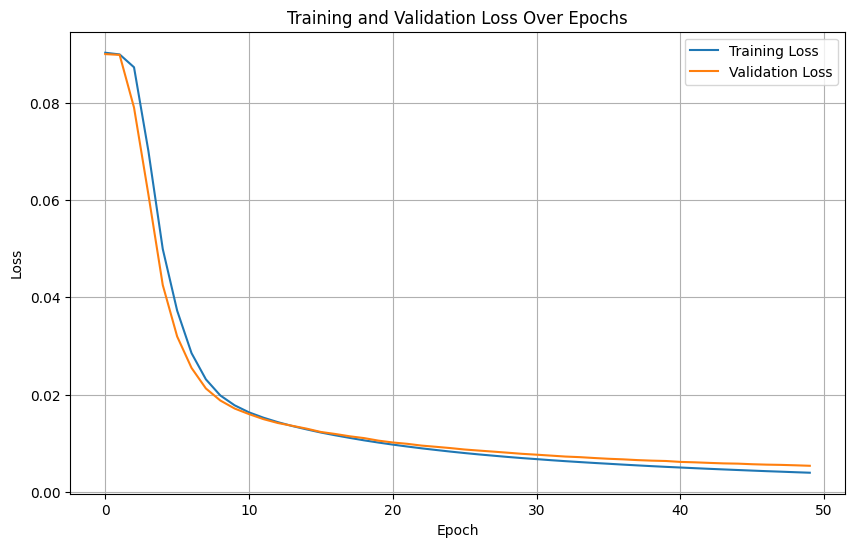

97.13000000000001


In [24]:
mlp = MLP(
    layers=[512, 256],
    activations=['sigmoid', 'sigmoid', 'sigmoid'],
    input_size=784,
    output_size=10,
    init_method='standard'
)

mlp.train(
    X_train, y_train, X_val, y_val,
    epochs=50,
    batch_size=64,
    learning_rate=0.1,
    optimizer='sgd',
    loss="MSE",
)
mlp.plot_losses()
print(mlp.evaluate(X_test,y_test))

Epoch 0: Validation Loss = 0.0501, validation Accuracy = 63.93%, Train Accuracy = 63.88%
Epoch 1: Validation Loss = 0.0200, validation Accuracy = 88.80%, Train Accuracy = 88.67%
Epoch 2: Validation Loss = 0.0153, validation Accuracy = 91.30%, Train Accuracy = 91.33%
Epoch 3: Validation Loss = 0.0124, validation Accuracy = 92.83%, Train Accuracy = 93.07%
Epoch 4: Validation Loss = 0.0109, validation Accuracy = 93.65%, Train Accuracy = 94.09%
Epoch 5: Validation Loss = 0.0098, validation Accuracy = 94.23%, Train Accuracy = 94.88%
Epoch 6: Validation Loss = 0.0084, validation Accuracy = 95.10%, Train Accuracy = 95.70%
Epoch 7: Validation Loss = 0.0077, validation Accuracy = 95.62%, Train Accuracy = 96.25%
Epoch 8: Validation Loss = 0.0073, validation Accuracy = 95.95%, Train Accuracy = 96.61%
Epoch 9: Validation Loss = 0.0066, validation Accuracy = 96.25%, Train Accuracy = 97.06%
Epoch 10: Validation Loss = 0.0063, validation Accuracy = 96.42%, Train Accuracy = 97.21%
Epoch 11: Validation

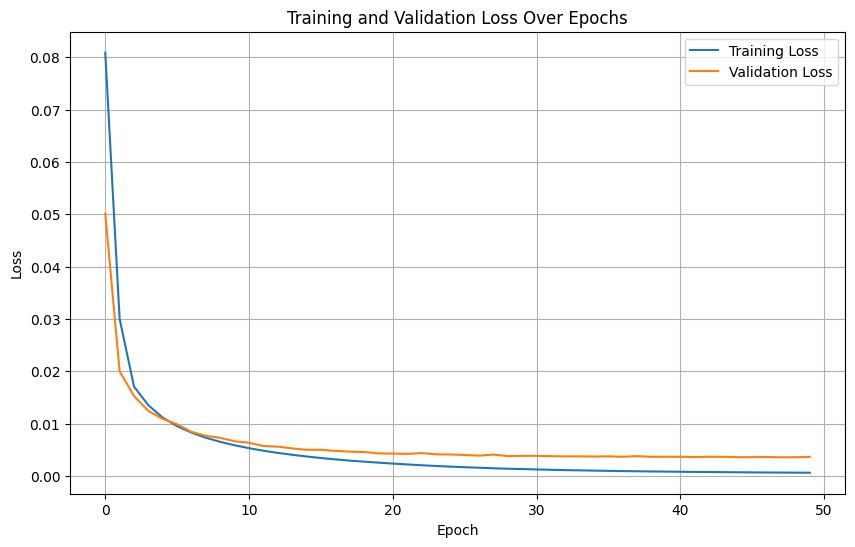

98.09


In [25]:
mlp = MLP(
    layers=[512, 512],
    activations=['sigmoid', 'sigmoid', 'sigmoid'],
    input_size=784,
    output_size=10,
    init_method='standard'
)

mlp.train(
    X_train, y_train, X_val, y_val,
    epochs=50,
    batch_size=16,
    learning_rate=0.1,
    optimizer='sgd',
    loss="MSE",
)
mlp.plot_losses()
print(mlp.evaluate(X_test,y_test))

Epoch 0: Validation Loss = 0.0900, validation Accuracy = 9.75%, Train Accuracy = 9.75%
Epoch 1: Validation Loss = 0.0900, validation Accuracy = 10.45%, Train Accuracy = 10.44%
Epoch 2: Validation Loss = 0.0896, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 3: Validation Loss = 0.0769, validation Accuracy = 31.47%, Train Accuracy = 30.91%
Epoch 4: Validation Loss = 0.0607, validation Accuracy = 56.35%, Train Accuracy = 56.18%
Epoch 5: Validation Loss = 0.0428, validation Accuracy = 74.27%, Train Accuracy = 73.68%
Epoch 6: Validation Loss = 0.0346, validation Accuracy = 80.90%, Train Accuracy = 80.63%
Epoch 7: Validation Loss = 0.0271, validation Accuracy = 85.30%, Train Accuracy = 85.16%
Epoch 8: Validation Loss = 0.0222, validation Accuracy = 87.62%, Train Accuracy = 87.57%
Epoch 9: Validation Loss = 0.0194, validation Accuracy = 89.00%, Train Accuracy = 88.76%
Epoch 10: Validation Loss = 0.0177, validation Accuracy = 89.98%, Train Accuracy = 89.73%
Epoch 11: Validation L

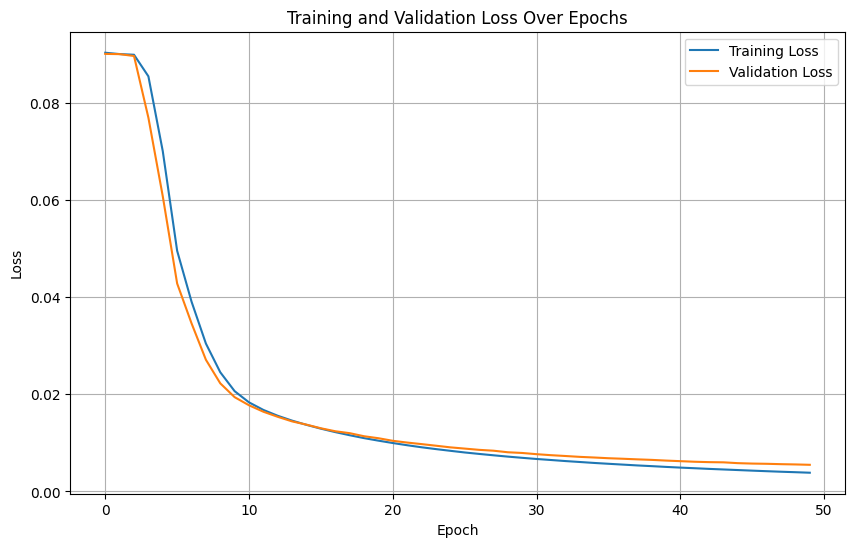

97.06


In [26]:
mlp = MLP(
    layers=[256, 256],
    activations=['sigmoid', 'sigmoid', 'sigmoid'],
    input_size=784,
    output_size=10,
    init_method='standard'
)

mlp.train(
    X_train, y_train, X_val, y_val,
    epochs=50,
    batch_size=64,
    learning_rate=0.1,
    optimizer='sgd',
    loss="MSE",
)
mlp.plot_losses()
print(mlp.evaluate(X_test,y_test))

Epoch 0: Validation Loss = 0.0900, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 1: Validation Loss = 0.0900, validation Accuracy = 10.45%, Train Accuracy = 10.44%
Epoch 2: Validation Loss = 0.0900, validation Accuracy = 9.92%, Train Accuracy = 9.91%
Epoch 3: Validation Loss = 0.0899, validation Accuracy = 14.38%, Train Accuracy = 14.82%
Epoch 4: Validation Loss = 0.0898, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 5: Validation Loss = 0.0895, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 6: Validation Loss = 0.0867, validation Accuracy = 22.22%, Train Accuracy = 22.62%
Epoch 7: Validation Loss = 0.0748, validation Accuracy = 34.22%, Train Accuracy = 33.92%
Epoch 8: Validation Loss = 0.0665, validation Accuracy = 43.33%, Train Accuracy = 43.64%
Epoch 9: Validation Loss = 0.0593, validation Accuracy = 56.05%, Train Accuracy = 56.29%
Epoch 10: Validation Loss = 0.0488, validation Accuracy = 69.43%, Train Accuracy = 68.79%
Epoch 11: Validation L

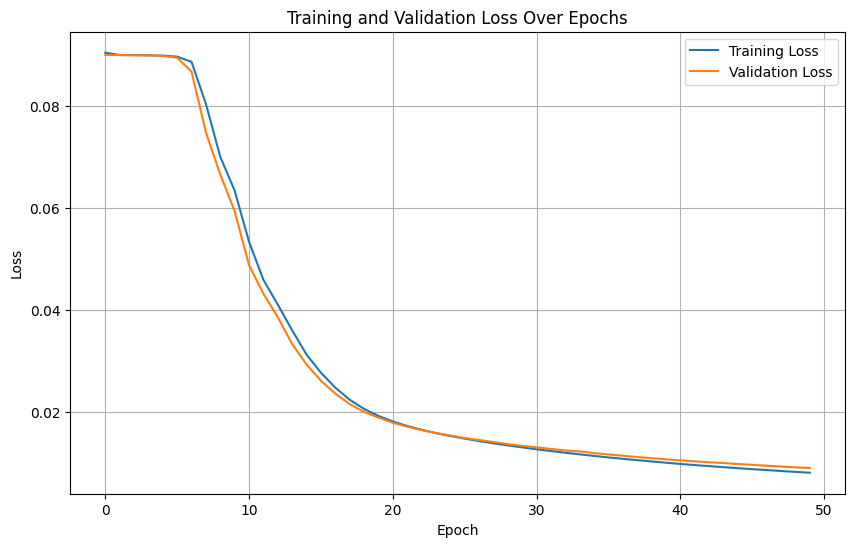

95.27


In [27]:
mlp = MLP(
    layers=[256, 256],
    activations=['sigmoid', 'sigmoid', 'sigmoid'],
    input_size=784,
    output_size=10,
    init_method='standard'
)

mlp.train(
    X_train, y_train, X_val, y_val,
    epochs=50,
    batch_size=128,
    learning_rate=0.1,
    optimizer='sgd',
    loss="MSE",
)
mlp.plot_losses()
print(mlp.evaluate(X_test,y_test))

Epoch 0: Validation Loss = 0.0899, validation Accuracy = 10.22%, Train Accuracy = 10.22%
Epoch 1: Validation Loss = 0.0813, validation Accuracy = 21.02%, Train Accuracy = 21.03%
Epoch 2: Validation Loss = 0.0508, validation Accuracy = 65.43%, Train Accuracy = 65.61%
Epoch 3: Validation Loss = 0.0364, validation Accuracy = 81.43%, Train Accuracy = 81.39%
Epoch 4: Validation Loss = 0.0269, validation Accuracy = 85.93%, Train Accuracy = 85.91%
Epoch 5: Validation Loss = 0.0223, validation Accuracy = 88.02%, Train Accuracy = 88.08%
Epoch 6: Validation Loss = 0.0196, validation Accuracy = 89.33%, Train Accuracy = 89.37%
Epoch 7: Validation Loss = 0.0180, validation Accuracy = 90.13%, Train Accuracy = 90.10%
Epoch 8: Validation Loss = 0.0165, validation Accuracy = 90.90%, Train Accuracy = 90.74%
Epoch 9: Validation Loss = 0.0155, validation Accuracy = 91.13%, Train Accuracy = 91.36%
Epoch 10: Validation Loss = 0.0147, validation Accuracy = 91.65%, Train Accuracy = 91.71%
Epoch 11: Validation

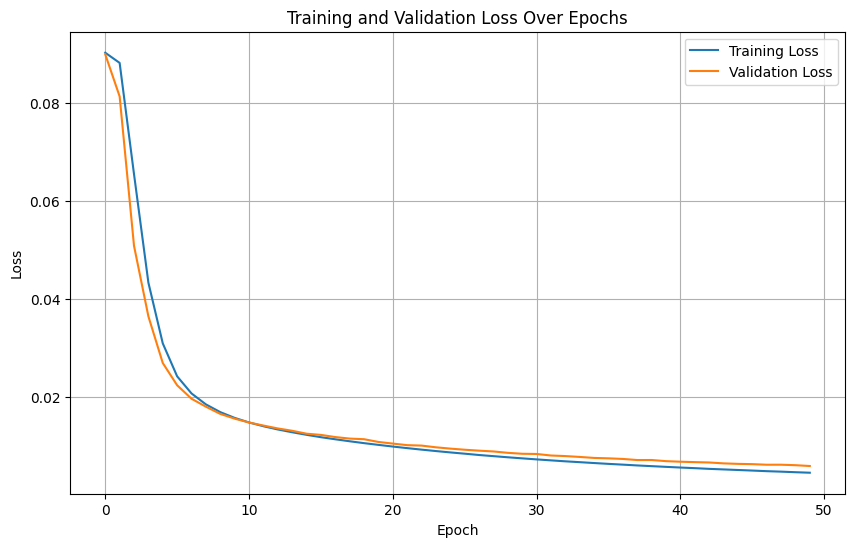

96.93


In [28]:
mlp = MLP(
    layers=[1024, 512],
    activations=['sigmoid', 'sigmoid', 'sigmoid'],
    input_size=784,
    output_size=10,
    init_method='standard'
)

mlp.train(
    X_train, y_train, X_val, y_val,
    epochs=50,
    batch_size=64,
    learning_rate=0.1,
    optimizer='sgd',
    loss="MSE",
)
mlp.plot_losses()
print(mlp.evaluate(X_test,y_test))

Epoch 0: Validation Loss = 0.0902, validation Accuracy = 9.03%, Train Accuracy = 9.04%
Epoch 1: Validation Loss = 0.0714, validation Accuracy = 45.82%, Train Accuracy = 45.62%
Epoch 2: Validation Loss = 0.0433, validation Accuracy = 73.53%, Train Accuracy = 73.78%
Epoch 3: Validation Loss = 0.0297, validation Accuracy = 84.73%, Train Accuracy = 84.99%
Epoch 4: Validation Loss = 0.0250, validation Accuracy = 87.38%, Train Accuracy = 87.35%
Epoch 5: Validation Loss = 0.0208, validation Accuracy = 89.22%, Train Accuracy = 89.05%
Epoch 6: Validation Loss = 0.0189, validation Accuracy = 90.12%, Train Accuracy = 89.94%
Epoch 7: Validation Loss = 0.0176, validation Accuracy = 90.58%, Train Accuracy = 90.44%
Epoch 8: Validation Loss = 0.0162, validation Accuracy = 91.18%, Train Accuracy = 91.24%
Epoch 9: Validation Loss = 0.0153, validation Accuracy = 91.78%, Train Accuracy = 91.77%
Epoch 10: Validation Loss = 0.0145, validation Accuracy = 92.02%, Train Accuracy = 92.21%
Epoch 11: Validation L

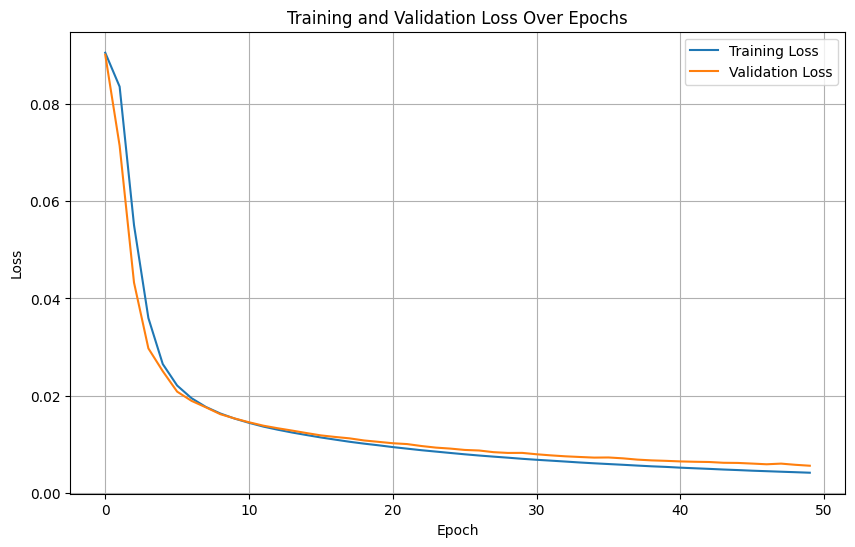

97.03


In [29]:
mlp = MLP(
    layers=[1024, 1024],
    activations=['sigmoid', 'sigmoid', 'sigmoid'],
    input_size=784,
    output_size=10,
    init_method='standard'
)

mlp.train(
    X_train, y_train, X_val, y_val,
    epochs=50,
    batch_size=64,
    learning_rate=0.1,
    optimizer='sgd',
    loss="MSE",
)
mlp.plot_losses()
print(mlp.evaluate(X_test,y_test))

Epoch 0: Validation Loss = 0.0900, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 1: Validation Loss = 0.0900, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 2: Validation Loss = 0.0900, validation Accuracy = 9.87%, Train Accuracy = 9.86%
Epoch 3: Validation Loss = 0.0899, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 4: Validation Loss = 0.0891, validation Accuracy = 25.08%, Train Accuracy = 25.57%
Epoch 5: Validation Loss = 0.0760, validation Accuracy = 32.23%, Train Accuracy = 32.58%
Epoch 6: Validation Loss = 0.0639, validation Accuracy = 49.43%, Train Accuracy = 49.56%
Epoch 7: Validation Loss = 0.0488, validation Accuracy = 70.10%, Train Accuracy = 69.88%
Epoch 8: Validation Loss = 0.0386, validation Accuracy = 77.52%, Train Accuracy = 77.41%
Epoch 9: Validation Loss = 0.0297, validation Accuracy = 83.75%, Train Accuracy = 83.51%
Epoch 10: Validation Loss = 0.0240, validation Accuracy = 86.43%, Train Accuracy = 86.74%
Epoch 11: Validation L

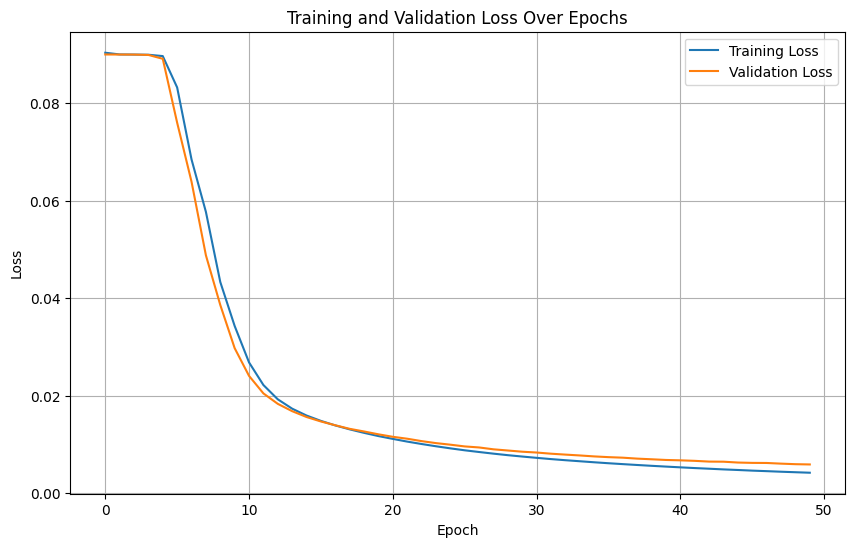

96.91


In [30]:
mlp = MLP(
    layers=[128, 128],
    activations=['sigmoid', 'sigmoid', 'sigmoid'],
    input_size=784,
    output_size=10,
    init_method='standard'
)

mlp.train(
    X_train, y_train, X_val, y_val,
    epochs=50,
    batch_size=64,
    learning_rate=0.1,
    optimizer='sgd',
    loss="MSE",
)
mlp.plot_losses()
print(mlp.evaluate(X_test,y_test))

Epoch 0: Validation Loss = 0.0900, validation Accuracy = 10.22%, Train Accuracy = 10.22%
Epoch 1: Validation Loss = 0.0900, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 2: Validation Loss = 0.0900, validation Accuracy = 10.45%, Train Accuracy = 10.44%
Epoch 3: Validation Loss = 0.0900, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 4: Validation Loss = 0.0900, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 5: Validation Loss = 0.0899, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 6: Validation Loss = 0.0896, validation Accuracy = 18.83%, Train Accuracy = 18.76%
Epoch 7: Validation Loss = 0.0815, validation Accuracy = 22.57%, Train Accuracy = 22.33%
Epoch 8: Validation Loss = 0.0747, validation Accuracy = 31.35%, Train Accuracy = 32.10%
Epoch 9: Validation Loss = 0.0727, validation Accuracy = 38.08%, Train Accuracy = 38.41%
Epoch 10: Validation Loss = 0.0658, validation Accuracy = 41.72%, Train Accuracy = 42.42%
Epoch 11: Validation

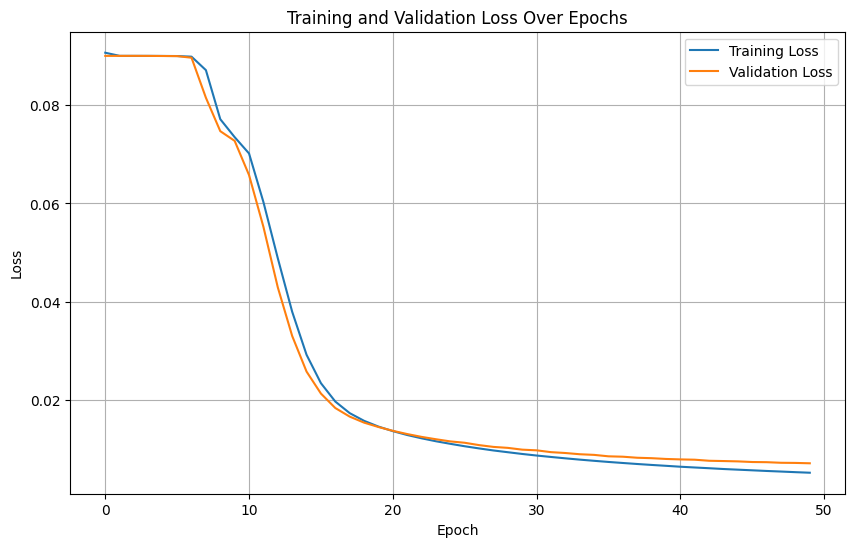

96.02000000000001


In [31]:
mlp = MLP(
    layers=[64, 64],
    activations=['sigmoid', 'sigmoid', 'sigmoid'],
    input_size=784,
    output_size=10,
    init_method='standard'
)

mlp.train(
    X_train, y_train, X_val, y_val,
    epochs=50,
    batch_size=64,
    learning_rate=0.1,
    optimizer='sgd',
    loss="MSE",
)
mlp.plot_losses()
print(mlp.evaluate(X_test,y_test))

Epoch 0: Validation Loss = 0.0900, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 1: Validation Loss = 0.0900, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 2: Validation Loss = 0.0900, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 3: Validation Loss = 0.0900, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 4: Validation Loss = 0.0900, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 5: Validation Loss = 0.0900, validation Accuracy = 10.22%, Train Accuracy = 10.22%
Epoch 6: Validation Loss = 0.0899, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 7: Validation Loss = 0.0899, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 8: Validation Loss = 0.0894, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 9: Validation Loss = 0.0831, validation Accuracy = 21.00%, Train Accuracy = 20.99%
Epoch 10: Validation Loss = 0.0807, validation Accuracy = 22.15%, Train Accuracy = 22.19%
Epoch 11: Validation

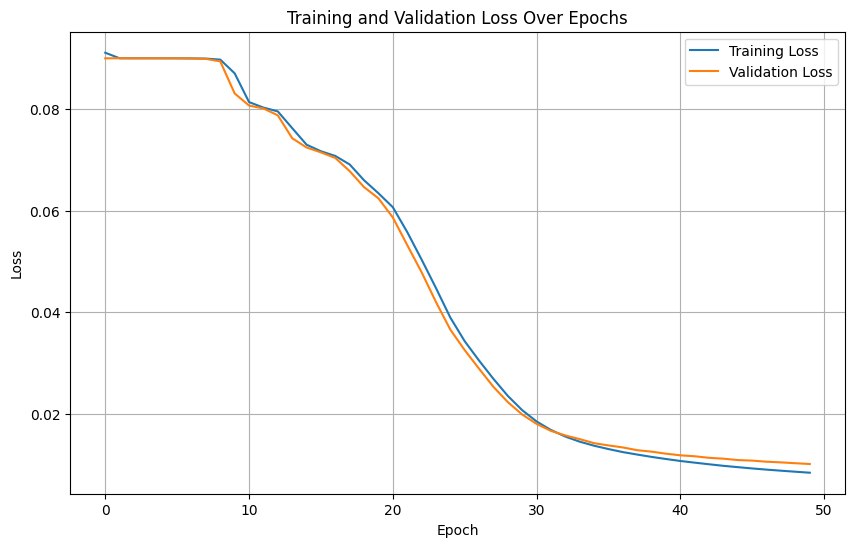

93.81


In [32]:
mlp = MLP(
    layers=[32, 32],
    activations=['sigmoid', 'sigmoid', 'sigmoid'],
    input_size=784,
    output_size=10,
    init_method='standard'
)

mlp.train(
    X_train, y_train, X_val, y_val,
    epochs=50,
    batch_size=64,
    learning_rate=0.1,
    optimizer='sgd',
    loss="MSE",
)
mlp.plot_losses()
print(mlp.evaluate(X_test,y_test))

Epoch 0: Validation Loss = 0.0900, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 1: Validation Loss = 0.0900, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 2: Validation Loss = 0.0900, validation Accuracy = 10.45%, Train Accuracy = 10.44%
Epoch 3: Validation Loss = 0.0900, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 4: Validation Loss = 0.0900, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 5: Validation Loss = 0.0900, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 6: Validation Loss = 0.0899, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 7: Validation Loss = 0.0899, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 8: Validation Loss = 0.0899, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 9: Validation Loss = 0.0897, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 10: Validation Loss = 0.0891, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 11: Validation

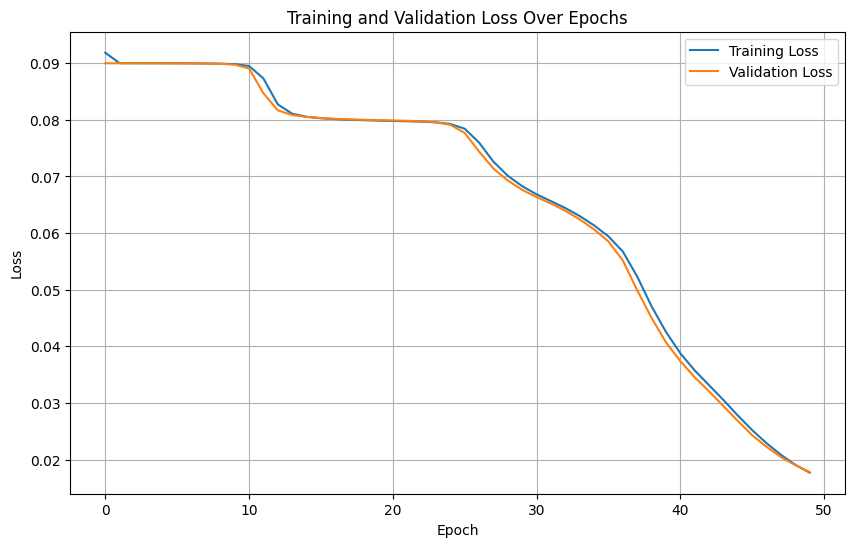

90.48


In [33]:
mlp = MLP(
    layers=[16, 16],
    activations=['sigmoid', 'sigmoid', 'sigmoid'],
    input_size=784,
    output_size=10,
    init_method='standard'
)

mlp.train(
    X_train, y_train, X_val, y_val,
    epochs=50,
    batch_size=64,
    learning_rate=0.1,
    optimizer='sgd',
    loss="MSE",
)
mlp.plot_losses()
print(mlp.evaluate(X_test,y_test))

## 3 Layer mlp with lr = 1 , 0.1 , 0.01 0.001

### lr 1

Epoch 0: Validation Loss = 0.1000, validation Accuracy = 9.87%, Train Accuracy = 9.87%
Epoch 1: Validation Loss = 0.1000, validation Accuracy = 9.87%, Train Accuracy = 9.87%
Epoch 2: Validation Loss = 0.1000, validation Accuracy = 9.87%, Train Accuracy = 9.87%
Epoch 3: Validation Loss = 0.1000, validation Accuracy = 9.87%, Train Accuracy = 9.87%
Epoch 4: Validation Loss = 0.1000, validation Accuracy = 9.87%, Train Accuracy = 9.87%
Epoch 5: Validation Loss = 0.1000, validation Accuracy = 9.87%, Train Accuracy = 9.87%
Epoch 6: Validation Loss = 0.1000, validation Accuracy = 9.87%, Train Accuracy = 9.87%
Epoch 7: Validation Loss = 0.1000, validation Accuracy = 9.87%, Train Accuracy = 9.87%
Epoch 8: Validation Loss = 0.1000, validation Accuracy = 9.87%, Train Accuracy = 9.87%
Epoch 9: Validation Loss = 0.1000, validation Accuracy = 9.87%, Train Accuracy = 9.87%
Epoch 10: Validation Loss = 0.1000, validation Accuracy = 9.87%, Train Accuracy = 9.87%
Epoch 11: Validation Loss = 0.1000, valida

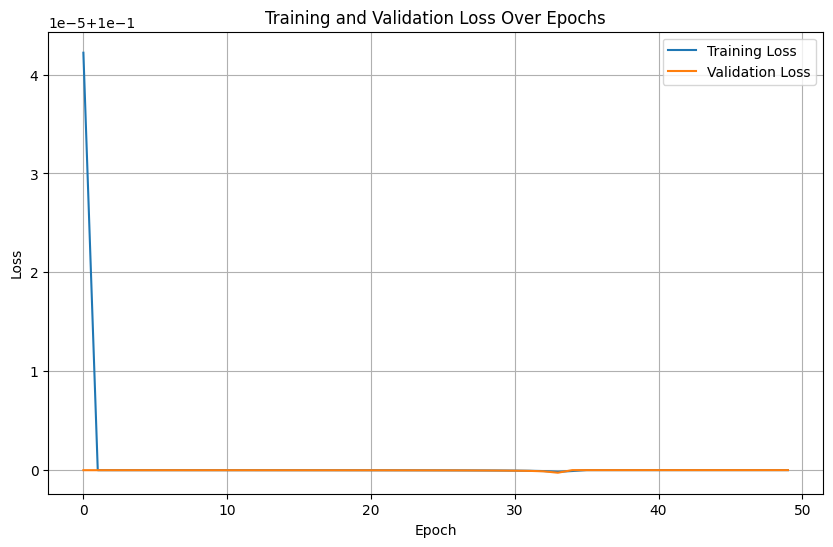

8.92


In [34]:
mlp = MLP(
    layers=[512, 512],
    activations=['sigmoid', 'sigmoid', 'sigmoid'],
    input_size=784,
    output_size=10,
    init_method='standard'
)

mlp.train(
    X_train, y_train, X_val, y_val,
    epochs=50,
    batch_size=16,
    learning_rate=1,
    optimizer='sgd',
    loss="MSE",
)
mlp.plot_losses()
print(mlp.evaluate(X_test,y_test))

### lr 0.1

Epoch 0: Validation Loss = 0.0506, validation Accuracy = 66.87%, Train Accuracy = 66.49%
Epoch 1: Validation Loss = 0.0203, validation Accuracy = 88.68%, Train Accuracy = 88.55%
Epoch 2: Validation Loss = 0.0152, validation Accuracy = 91.30%, Train Accuracy = 91.36%
Epoch 3: Validation Loss = 0.0125, validation Accuracy = 92.68%, Train Accuracy = 93.08%
Epoch 4: Validation Loss = 0.0109, validation Accuracy = 93.70%, Train Accuracy = 94.10%
Epoch 5: Validation Loss = 0.0097, validation Accuracy = 94.40%, Train Accuracy = 94.98%
Epoch 6: Validation Loss = 0.0085, validation Accuracy = 95.22%, Train Accuracy = 95.67%
Epoch 7: Validation Loss = 0.0077, validation Accuracy = 95.55%, Train Accuracy = 96.19%
Epoch 8: Validation Loss = 0.0071, validation Accuracy = 95.82%, Train Accuracy = 96.60%
Epoch 9: Validation Loss = 0.0066, validation Accuracy = 96.20%, Train Accuracy = 97.00%
Epoch 10: Validation Loss = 0.0061, validation Accuracy = 96.53%, Train Accuracy = 97.34%
Epoch 11: Validation

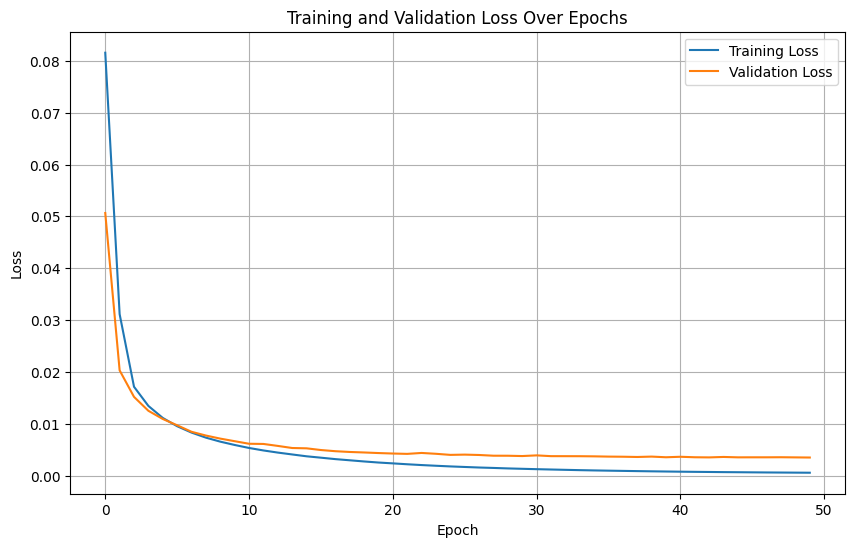

98.07000000000001


In [35]:
mlp = MLP(
    layers=[512, 512],
    activations=['sigmoid', 'sigmoid', 'sigmoid'],
    input_size=784,
    output_size=10,
    init_method='standard'
)

mlp.train(
    X_train, y_train, X_val, y_val,
    epochs=50,
    batch_size=16,
    learning_rate=0.1,
    optimizer='sgd',
    loss="MSE",
)
mlp.plot_losses()
print(mlp.evaluate(X_test,y_test))

### lr 0.01

Epoch 0: Validation Loss = 0.0900, validation Accuracy = 9.93%, Train Accuracy = 9.93%
Epoch 1: Validation Loss = 0.0899, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 2: Validation Loss = 0.0898, validation Accuracy = 11.88%, Train Accuracy = 11.98%
Epoch 3: Validation Loss = 0.0896, validation Accuracy = 21.58%, Train Accuracy = 21.79%
Epoch 4: Validation Loss = 0.0888, validation Accuracy = 22.28%, Train Accuracy = 22.59%
Epoch 5: Validation Loss = 0.0812, validation Accuracy = 22.03%, Train Accuracy = 22.12%
Epoch 6: Validation Loss = 0.0728, validation Accuracy = 43.42%, Train Accuracy = 43.34%
Epoch 7: Validation Loss = 0.0643, validation Accuracy = 50.88%, Train Accuracy = 51.40%
Epoch 8: Validation Loss = 0.0517, validation Accuracy = 68.13%, Train Accuracy = 68.26%
Epoch 9: Validation Loss = 0.0451, validation Accuracy = 70.27%, Train Accuracy = 70.54%
Epoch 10: Validation Loss = 0.0405, validation Accuracy = 76.00%, Train Accuracy = 76.01%
Epoch 11: Validation L

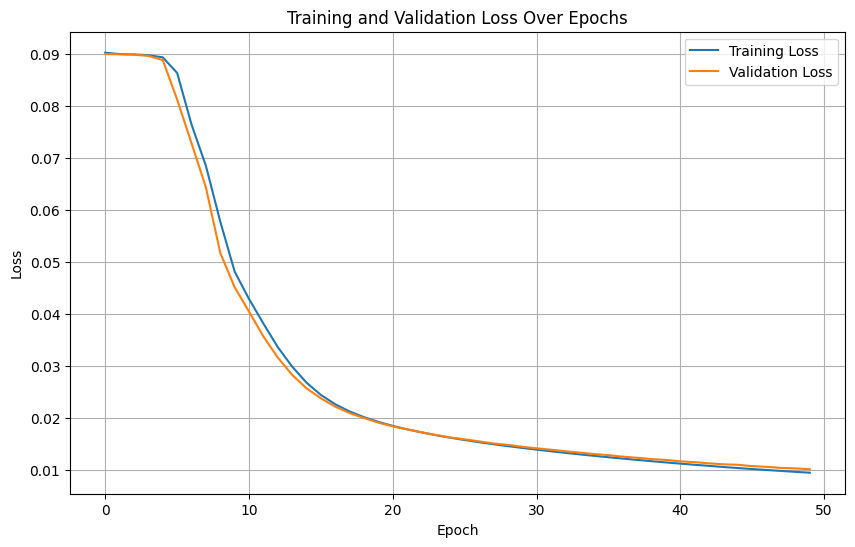

94.36


In [36]:
mlp = MLP(
    layers=[512, 512],
    activations=['sigmoid', 'sigmoid', 'sigmoid'],
    input_size=784,
    output_size=10,
    init_method='standard'
)

mlp.train(
    X_train, y_train, X_val, y_val,
    epochs=50,
    batch_size=16,
    learning_rate=0.01,
    optimizer='sgd',
    loss="MSE",
)
mlp.plot_losses()
print(mlp.evaluate(X_test,y_test))

### lr 0.001

Epoch 0: Validation Loss = 0.0900, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 1: Validation Loss = 0.0900, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 2: Validation Loss = 0.0900, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 3: Validation Loss = 0.0900, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 4: Validation Loss = 0.0900, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 5: Validation Loss = 0.0900, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 6: Validation Loss = 0.0900, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 7: Validation Loss = 0.0900, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 8: Validation Loss = 0.0900, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 9: Validation Loss = 0.0900, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 10: Validation Loss = 0.0900, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 11: Validation

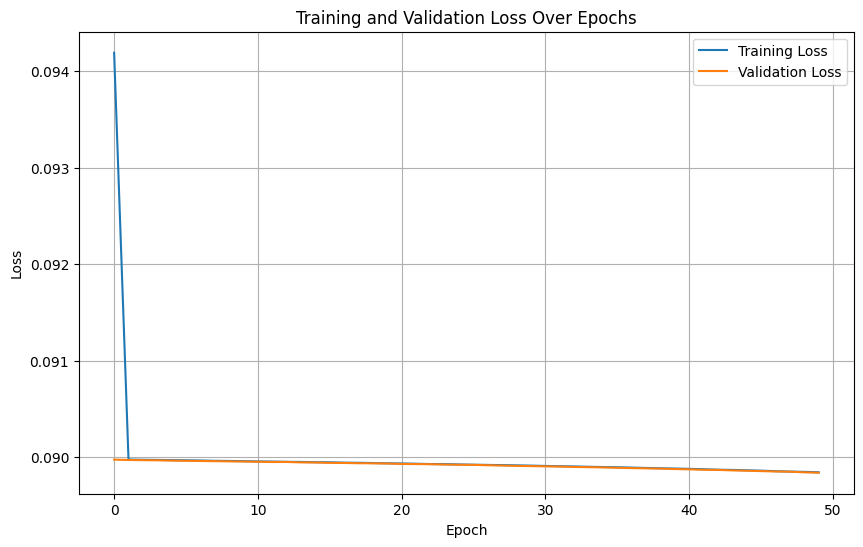

11.35


In [39]:
mlp = MLP(
    layers=[512, 512],
    activations=['sigmoid', 'sigmoid', 'sigmoid'],
    input_size=784,
    output_size=10,
    init_method='standard'
)

mlp.train(
    X_train, y_train, X_val, y_val,
    epochs=50,
    batch_size=32,
    learning_rate=0.001,
    optimizer='sgd',
    loss="MSE",
)
mlp.plot_losses()
print(mlp.evaluate(X_test,y_test))

# Phase 3: Optimization

## Nesterov Momentum

Epoch 0: Validation Loss = 0.1000, validation Accuracy = 10.45%, Train Accuracy = 10.44%
Epoch 1: Validation Loss = 0.1000, validation Accuracy = 10.45%, Train Accuracy = 10.44%
Epoch 2: Validation Loss = 0.1000, validation Accuracy = 10.45%, Train Accuracy = 10.44%
Epoch 3: Validation Loss = 0.1000, validation Accuracy = 10.45%, Train Accuracy = 10.44%
Epoch 4: Validation Loss = 0.1000, validation Accuracy = 10.45%, Train Accuracy = 10.44%
Epoch 5: Validation Loss = 0.1000, validation Accuracy = 10.45%, Train Accuracy = 10.44%
Epoch 6: Validation Loss = 0.1000, validation Accuracy = 10.45%, Train Accuracy = 10.44%
Epoch 7: Validation Loss = 0.1000, validation Accuracy = 10.45%, Train Accuracy = 10.44%
Epoch 8: Validation Loss = 0.1000, validation Accuracy = 10.45%, Train Accuracy = 10.44%
Epoch 9: Validation Loss = 0.1000, validation Accuracy = 10.45%, Train Accuracy = 10.44%
Epoch 10: Validation Loss = 0.1000, validation Accuracy = 10.45%, Train Accuracy = 10.44%
Epoch 11: Validation

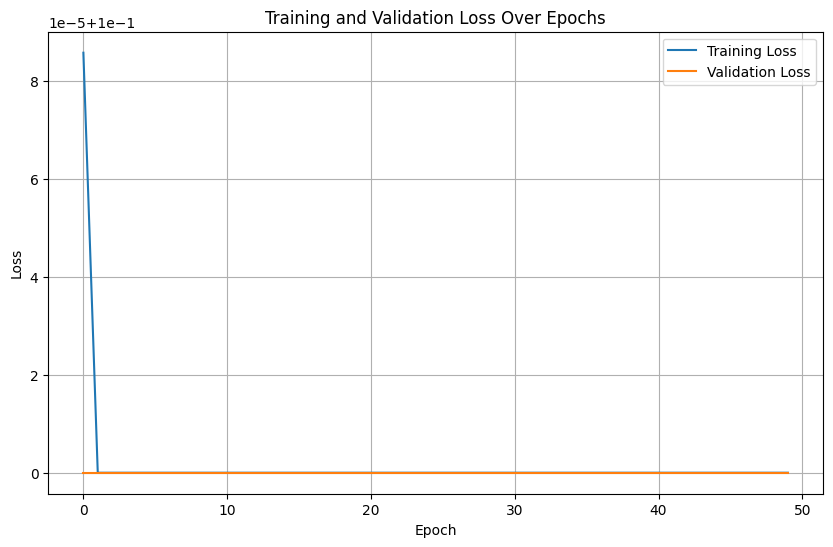

10.280000000000001


In [6]:
mlp = MLP(
    layers=[512, 512],
    activations=['sigmoid', 'sigmoid', 'sigmoid'],
    input_size=784,
    output_size=10,
    init_method='standard'
)

mlp.train(
    X_train, y_train, X_val, y_val,
    epochs=50,
    batch_size=32,
    learning_rate=0.1,
    optimizer='nesterov',
    loss="MSE",
)
mlp.plot_losses()
print(mlp.evaluate(X_test,y_test))

## AdaGrad

Epoch 0: Validation Loss = 0.1000, validation Accuracy = 10.45%, Train Accuracy = 10.44%
Epoch 1: Validation Loss = 0.1000, validation Accuracy = 10.45%, Train Accuracy = 10.44%
Epoch 2: Validation Loss = 0.1000, validation Accuracy = 10.45%, Train Accuracy = 10.44%
Epoch 3: Validation Loss = 0.1000, validation Accuracy = 10.45%, Train Accuracy = 10.44%
Epoch 4: Validation Loss = 0.1000, validation Accuracy = 10.45%, Train Accuracy = 10.44%
Epoch 5: Validation Loss = 0.1000, validation Accuracy = 10.45%, Train Accuracy = 10.44%
Epoch 6: Validation Loss = 0.1000, validation Accuracy = 10.45%, Train Accuracy = 10.44%
Epoch 7: Validation Loss = 0.1000, validation Accuracy = 10.45%, Train Accuracy = 10.44%
Epoch 8: Validation Loss = 0.1000, validation Accuracy = 10.45%, Train Accuracy = 10.44%
Epoch 9: Validation Loss = 0.1000, validation Accuracy = 10.45%, Train Accuracy = 10.44%
Epoch 10: Validation Loss = 0.1000, validation Accuracy = 10.45%, Train Accuracy = 10.44%
Epoch 11: Validation

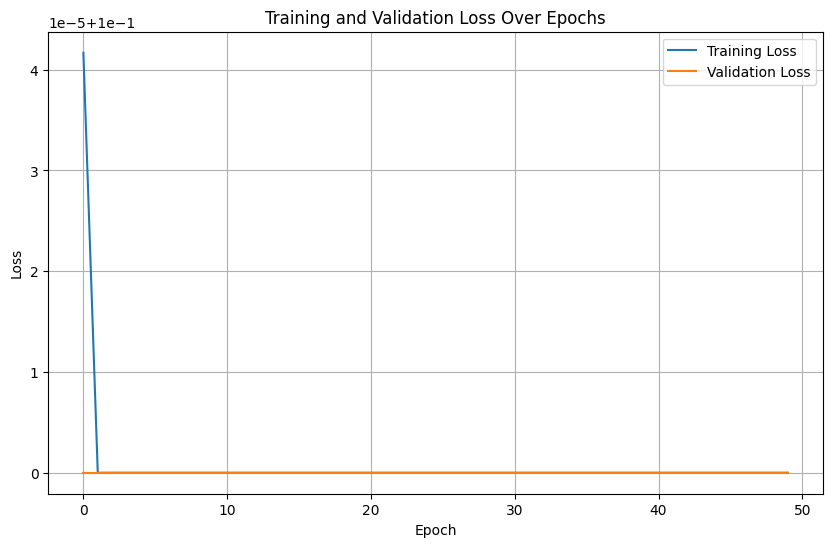

10.280000000000001


In [7]:
mlp = MLP(
    layers=[512, 512],
    activations=['sigmoid', 'sigmoid', 'sigmoid'],
    input_size=784,
    output_size=10,
    init_method='standard'
)

mlp.train(
    X_train, y_train, X_val, y_val,
    epochs=50,
    batch_size=16,
    learning_rate=0.1,
    optimizer='adagrad',
    loss="MSE",
)
mlp.plot_losses()
print(mlp.evaluate(X_test,y_test))

## RMSPop

Epoch 0: Validation Loss = 0.1000, validation Accuracy = 10.22%, Train Accuracy = 10.22%
Epoch 1: Validation Loss = 0.1000, validation Accuracy = 10.22%, Train Accuracy = 10.22%
Epoch 2: Validation Loss = 0.1000, validation Accuracy = 10.22%, Train Accuracy = 10.22%
Epoch 3: Validation Loss = 0.1000, validation Accuracy = 10.22%, Train Accuracy = 10.22%
Epoch 4: Validation Loss = 0.1000, validation Accuracy = 10.22%, Train Accuracy = 10.22%
Epoch 5: Validation Loss = 0.1000, validation Accuracy = 10.22%, Train Accuracy = 10.22%
Epoch 6: Validation Loss = 0.1000, validation Accuracy = 10.22%, Train Accuracy = 10.22%
Epoch 7: Validation Loss = 0.1000, validation Accuracy = 10.22%, Train Accuracy = 10.22%
Epoch 8: Validation Loss = 0.1000, validation Accuracy = 10.22%, Train Accuracy = 10.22%
Epoch 9: Validation Loss = 0.1000, validation Accuracy = 10.22%, Train Accuracy = 10.22%
Epoch 10: Validation Loss = 0.1000, validation Accuracy = 10.22%, Train Accuracy = 10.22%
Epoch 11: Validation

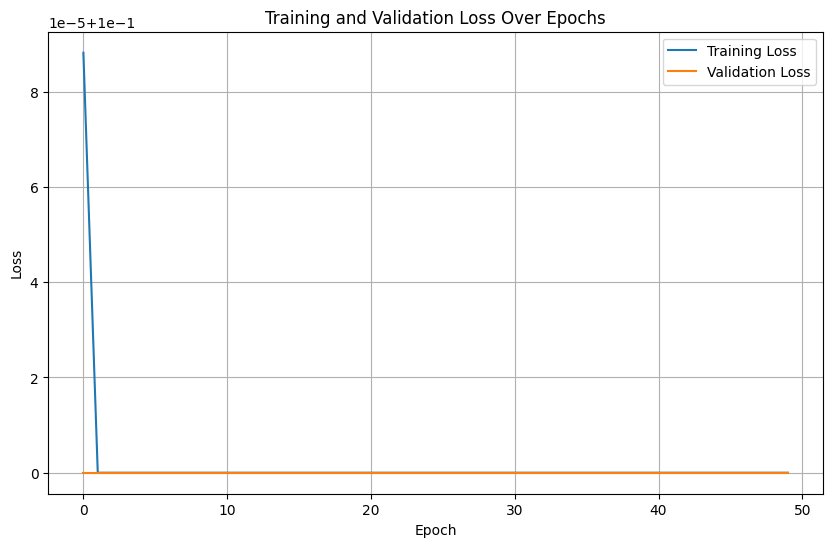

10.100000000000001


In [8]:
mlp = MLP(
    layers=[512, 512],
    activations=['sigmoid', 'sigmoid', 'sigmoid'],
    input_size=784,
    output_size=10,
    init_method='standard'
)

mlp.train(
    X_train, y_train, X_val, y_val,
    epochs=50,
    batch_size=32,
    learning_rate=0.1,
    optimizer='rmsprop',
    loss="MSE",
)
mlp.plot_losses()
print(mlp.evaluate(X_test,y_test))

## Adam

In [11]:
mlp = MLP(
    layers=[512, 256],
    activations=['sigmoid', 'sigmoid', 'sigmoid'],
    input_size=784,
    output_size=10,
    init_method='standard'
)

mlp.train(
    X_train, y_train, X_val, y_val,
    epochs=50,
    batch_size=32,
    learning_rate=0.01,
    optimizer='adam',
    loss="MSE",
)
mlp.plot_losses()
print(mlp.evaluate(X_test,y_test))

Epoch 0: Validation Loss = 0.0985, validation Accuracy = 9.93%, Train Accuracy = 9.93%
Epoch 1: Validation Loss = 0.1000, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 2: Validation Loss = 0.1000, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 3: Validation Loss = 0.1000, validation Accuracy = 9.03%, Train Accuracy = 9.04%
Epoch 4: Validation Loss = 0.1000, validation Accuracy = 9.87%, Train Accuracy = 9.86%
Epoch 5: Validation Loss = 0.1000, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 6: Validation Loss = 0.1000, validation Accuracy = 11.23%, Train Accuracy = 11.24%
Epoch 7: Validation Loss = 0.1000, validation Accuracy = 9.92%, Train Accuracy = 9.91%
Epoch 8: Validation Loss = 0.1000, validation Accuracy = 9.92%, Train Accuracy = 9.91%
Epoch 9: Validation Loss = 0.1000, validation Accuracy = 9.75%, Train Accuracy = 9.75%
Epoch 10: Validation Loss = 0.1000, validation Accuracy = 9.75%, Train Accuracy = 9.75%
Epoch 11: Validation Loss = 0.1000

KeyboardInterrupt: 

# Phase4: Vanishing Gradient and Weight Initialization

## Standard init and sigmoid

In [12]:
mlp = MLP(
    layers=[256,256,256,256,256,256],
    activations=['sigmoid', 'sigmoid', 'sigmoid','sigmoid', 'sigmoid', 'sigmoid'],
    input_size=784,
    output_size=10,
    init_method='standard'
)

mlp.train(
    X_train, y_train, X_val, y_val,
    epochs=50,
    batch_size=32,
    learning_rate=0.1,
    optimizer='adam',
    loss="MSE",
)
mlp.plot_losses()
mlp.plot_weights()
print(mlp.evaluate(X_test,y_test))

Exception ignored in: 'zmq.backend.cython._zmq.Frame.__del__'
Traceback (most recent call last):
  File "_zmq.py", line 160, in zmq.backend.cython._zmq._check_rc
KeyboardInterrupt: 


KeyboardInterrupt: 

## Xavier and sigmoid

In [ ]:
mlp = MLP(
    layers=[256,256,256,256,256,256],
    activations=['sigmoid', 'sigmoid', 'sigmoid','sigmoid', 'sigmoid', 'sigmoid'],
    input_size=784,
    output_size=10,
    init_method='xavier'
)

mlp.train(
    X_train, y_train, X_val, y_val,
    epochs=50,
    batch_size=32,
    learning_rate=0.1,
    optimizer='adam',
    loss="MSE",
)
mlp.plot_losses()
mlp.plot_weights()
print(mlp.evaluate(X_test,y_test))

## Xavier and Relu

In [ ]:
mlp = MLP(
    layers=[256,256,256,256,256,256],
    activations=['relu', 'relu', 'relu','relu', 'relu', 'relu'],
    input_size=784,
    output_size=10,
    init_method='standard'
)

mlp.train(
    X_train, y_train, X_val, y_val,
    epochs=50,
    batch_size=32,
    learning_rate=0.1,
    optimizer='adam',
    loss="MSE",
)
mlp.plot_losses()
mlp.plot_weights()
print(mlp.evaluate(X_test,y_test))

# Phase 5: SofttMax + Cross-Entropy

In [14]:
mlp = MLP(
    layers=[256,256,256,256,256,256],
    activations=['relu', 'relu', 'relu','relu', 'relu', 'softmax'],
    input_size=784,
    output_size=10,
    init_method='xavier'
)

mlp.train(
    X_train, y_train, X_val, y_val,
    epochs=50,
    batch_size=32,
    learning_rate=0.1,
    optimizer='adam',
    loss="crossentropy",
)
mlp.plot_losses()
mlp.plot_weights()
print(mlp.evaluate(X_test,y_test))

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

# Phase 6: PCA

In [ ]:
pca = PCA()
pca.fit(X_train)
cumulative_variance = pca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(10, 6))
# plt.plot(range(1, n_components + 1), cumulative_variance, marker='o')
plt.plot(range(1, 101), cumulative_variance[:100], marker='o') 
plt.title("Cumulative Variance Explained by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Explained")
plt.axhline(y=0.80, color='r', linestyle='--')
plt.axhline(y=0.90, color='r', linestyle='--')  
plt.axhline(y=0.70, color='r', linestyle='--')  


plt.grid()
plt.show()

best_n_components70 = np.argmax(cumulative_variance >= 0.80) + 1
best_n_components80 = np.argmax(cumulative_variance >= 0.80) + 1
best_n_components90 = np.argmax(cumulative_variance >= 0.80) + 1
print(f"Number of components to explain at least 70% 80% 90% variance: {best_n_components70,best_n_components80,best_n_components90}")